# Load Packages, Variables

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf


from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

import sys
sys.path.append('../')
from ficc_keras_utils import *
import ficc_keras_utils
from lgbm_tools import *
from ficc_debiasing import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

2023-07-18 18:30:46.859563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-18 18:30:46.872145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-18 18:30:46.873784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
TF Version: 2.7.0


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

##COMMON VARIABLES
#DATA WINDOW
train_start = '2023-05-01'
train_end = '2023-06-01'
test_start = '2023-06-01'
test_end = '2023-07-01'
#MODEL PARAMETERS 
VALIDATION_SPLIT = ficc_keras_utils.VALIDATION_SPLIT
LEARNING_RATE = ficc_keras_utils.LEARNING_RATE
BATCH_SIZE = 1000 #ficc_keras_utils.BATCH_SIZE
NUM_EPOCHS = 75 #ficc_keras_utils.NUM_EPOCHS
DROPOUT = 0.01 #ficc_keras_utils.DROPOUT

##NOTEBOOK SPECIFIC VARIABLES 
TRADE_SEQUENCE_LENGTH = 2
NUM_FEATURES = 6
# target_variable = 'new_ys_diff'
# target_variable = 'new_ys' 
target_variable = 'new_ys' 

In [3]:
print(train_start ,
train_end ,
test_start ,
test_end)

2023-05-01 2023-06-01 2023-06-01 2023-07-01


# Load Data and Train NN

In [4]:
%time processed_data = load_data_from_pickle('processed_file_FULL_2023-07-12-17:22.pkl')

File available, loading pickle
CPU times: user 7.3 s, sys: 2.71 s, total: 10 s
Wall time: 10 s


In [5]:
processed_data = processed_data[~(processed_data.trade_history.apply(lambda x: x.shape) == (5,6))]

In [6]:
processed_data['trade_history'] = processed_data.trade_history.apply(lambda x: x[:,[0,2,3,4,5,6]])

In [7]:
processed_data['target_attention_features'] = processed_data['target_attention_features'].apply(lambda x: x[[0],:])

In [8]:
processed_data['target_attention_features'].iloc[0].shape

(1, 3)

## Checking data

In [9]:
processed_data.trade_date.min(), processed_data.trade_date.max()

(Timestamp('2023-05-01 00:00:00'), Timestamp('2023-07-11 00:00:00'))

In [10]:
processed_data[['yield','new_real_time_ficc_ycl']].describe()

,yield,new_real_time_ficc_ycl
count,1746702.000,1746702.000
mean,364.498,323.013
std,91.917,41.183
min,0.100,263.663
25%,307.000,297.164
50%,350.300,310.806
75%,411.000,336.136
max,9892.500,541.456


In [11]:
processed_data.reset_index(drop=True, inplace=True)

In [12]:
processed_data['new_ys_realtime'] = processed_data['yield'] - processed_data['new_real_time_ficc_ycl']
processed_data['new_ys'] = processed_data['yield'] - processed_data['new_ficc_ycl']

In [13]:
##### EXTRA DATA PREPROCESSING #####
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] + row.trade_type
    seconds_ago = trade[5]
    quantity_diff = np.log10(1 + np.abs(10**trade[2] - 10**row.quantity))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

def process_data(data): 
    data['ted-rate'] = (data['t_rate_10'] - data['t_rate_2']) * 100
    
    data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
    data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
    data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
    data = data[data.days_to_maturity < np.log10(30000)]
    data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))
    data.issue_amount = data.issue_amount.replace([np.inf, -np.inf], np.nan)
    data.dropna(inplace=True, subset=PREDICTORS+['trade_history_sum'])
    data.purpose_sub_class.fillna(0, inplace=True)
    
    return data

In [14]:
%%time
temp = processed_data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
YS_COLS = get_trade_history_columns()
processed_data[YS_COLS] = pd.DataFrame(temp.tolist(), index=processed_data.index)

CPU times: user 34.2 s, sys: 5.79 s, total: 39.9 s
Wall time: 1min 32s


In [16]:
processed_data['ttypes'] = (processed_data.last_trade_type.astype(str) + processed_data.trade_type.astype(str)).astype('category')
processed_data['diff_size'] = (processed_data.par_traded.astype(float) - processed_data.last_size).astype(np.float32)
processed_data['abs_last_yield_spread'] = np.abs(processed_data['last_yield_spread'])
processed_data['abs_diff_size'] = np.abs(processed_data['diff_size'])
processed_data['days_duration'] = (processed_data.last_calc_date - processed_data.last_settlement_date).dt.days

In [17]:
%%time
processed_data['trade_history_sum'] = processed_data.trade_history.parallel_apply(lambda x: np.sum(x))
processed_data = processed_data.dropna(subset=['trade_history_sum'])
processed_data.purpose_sub_class.fillna(0, inplace=True)

CPU times: user 14.3 s, sys: 3.94 s, total: 18.2 s
Wall time: 19.6 s


In [18]:
# for col in NON_CAT_FEATURES:
#     print(col + ':' + str(train_dataframe[col].isna().sum()))

In [19]:
for col in ['new_ficc_ycl', 'yield_spread']:
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)
    if col in PREDICTORS:
        PREDICTORS.remove(col)
        
# for col in ['rating']:
#     if col in CATEGORICAL_FEATURES:
#         CATEGORICAL_FEATURES.remove(col)
#     if col in PREDICTORS:
#         PREDICTORS.remove(col)

In [20]:
processed_data = process_data(processed_data)

In [21]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']
YS_COLS = ['max_ys_ys', 'max_ys_ttypes', 'max_ys_ago', 'max_ys_qdiff', 'min_ys_ys', 'min_ys_ttypes', 'min_ys_ago', 'min_ys_qdiff', 'max_qty_ys', 'max_qty_ttypes', \
           'max_qty_ago', 'max_qty_qdiff', 'min_ago_ys', 'min_ago_ttypes', 'min_ago_ago', 'min_ago_qdiff', 'D_min_ago_ys', 'D_min_ago_ttypes', 'D_min_ago_ago', 'D_min_ago_qdiff',\
           'P_min_ago_ys', 'P_min_ago_ttypes', 'P_min_ago_ago', 'P_min_ago_qdiff', 'S_min_ago_ys', 'S_min_ago_ttypes', 'S_min_ago_ago', 'S_min_ago_qdiff']
    
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)
        
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
    
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
    
for col in ['new_ficc_ycl', 'new_real_time_ficc_ycl']:     
    if col not in PREDICTORS:
        PREDICTORS.append(col)
        NON_CAT_FEATURES.append(col)
        
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes


In [22]:
%%time

processed_data['trade_history_shortened'] = processed_data['trade_history'].apply(lambda x: x[:TRADE_SEQUENCE_LENGTH])

CPU times: user 872 ms, sys: 11.7 ms, total: 884 ms
Wall time: 883 ms


In [23]:
%%time

processed_data['trade_history_fixed'] = processed_data['trade_history_shortened'].apply(lambda x: x[::-1, :])

CPU times: user 931 ms, sys: 34.7 ms, total: 966 ms
Wall time: 965 ms


In [24]:
processed_data.trade_date.min(), processed_data.trade_date.max(), len(processed_data)

(Timestamp('2023-05-01 00:00:00'), Timestamp('2023-07-11 00:00:00'), 1590785)

In [25]:
processed_data.to_pickle('processed_data_ratings_comparison.pkl')

In [26]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)
                                                            
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

Training data start: 2023-05-01 00:00:00, end: 2023-05-31 00:00:00
Test data start: 2023-06-01 00:00:00, end: 2023-06-30 00:00:00


In [27]:
print(train_dataframe.trade_date.min(), train_dataframe.trade_date.max(), len(train_dataframe))
print(test_dataframe.trade_date.min(), test_dataframe.trade_date.max(), len(test_dataframe))

2023-05-01 00:00:00 2023-05-31 00:00:00 705233
2023-06-01 00:00:00 2023-06-30 00:00:00 697202


In [28]:
def create_input_new(df, trade_history_col):
    global encoders
    trade_history_input = []
    reference_input = []
        
    trade_history_input.append(np.stack(df[trade_history_col].to_numpy()))
    trade_history_input.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    reference_input.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        reference_input.append(encoded.astype('float32'))
    
    return trade_history_input, reference_input

def generate_trade_history_model(TRADE_SEQUENCE_LENGTH, trade_history_normalizer):

    inputs = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[0]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
    
    trade_history_output = layers.Dense(1)(trade_history_output)

    model = keras.Model(inputs=inputs, outputs=trade_history_output)
    
    return model
    

def generate_reference_model(noncat_binary_normalizer):
    inputs = []
    layer = []

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[0]))
    
    global encoders
    for f in CATEGORICAL_FEATURES:
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(300,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_hidden3 = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)
    reference_hidden3 = layers.BatchNormalization()(reference_hidden3)
    reference_hidden3 = layers.Dropout(DROPOUT)(reference_hidden3)
    
    reference_output = layers.Dense(1, name='reference_hidden_3')(reference_hidden2)

    model = keras.Model(inputs=inputs, outputs=reference_output)
    
    return model


def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH}
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    
    trade_history_x_train, reference_x_train = create_input_new(train_dataframe.drop(val_idx, axis=0), trade_history_col)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    trade_history_x_val, reference_x_val = create_input_new(train_dataframe.iloc[val_idx], trade_history_col)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    trade_history_x_test, reference_x_test = create_input_new(test_dataframe, trade_history_col)
    y_test = test_dataframe[target_variable]    
    
    # Normalization layer for the trade history
    trade_history_normalizer = Normalization(name='Trade_history_normalizer')
    trade_history_normalizer.adapt(trade_history_x_train[0], batch_size=BATCH_SIZE)

    # Normalization layer for the non-categorical and binary features
    noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
    noncat_binary_normalizer.adapt(reference_x_train[0], batch_size = BATCH_SIZE)

    normalizers = {'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, [trade_history_x_train, reference_x_train], y_train, [trade_history_x_val, reference_x_val], y_val, [trade_history_x_test, reference_x_test], y_test, val_idx

In [29]:
def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset

In [30]:
def train_model_new(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1, 
                    epochs = {'trade_history_model':NUM_EPOCHS, 'reference_model':NUM_EPOCHS}):
    tf.keras.backend.clear_session()
    gc.collect()

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
      
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    trade_history_model = generate_trade_history_model(TRADE_SEQUENCE_LENGTH, trade_history_normalizer)
    reference_model = generate_reference_model(noncat_binary_normalizer)
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # time_callback,
        # CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)
    ]
    
    with tf.device('/cpu:0'):
        trade_history_train_ds = create_tf_data(x_train[0], y_train, shuffle, shuffle_buffer).batch(BATCH_SIZE).prefetch(2).cache()
        trade_history_val_ds = create_tf_data(x_val[0], y_val, shuffle = False).batch(BATCH_SIZE).prefetch(2).cache()
        
        reference_model_train_ds = create_tf_data(x_train[1], y_train, shuffle, shuffle_buffer).batch(BATCH_SIZE).prefetch(2).cache()
        reference_model_val_ds = create_tf_data(x_val[1], y_val, shuffle = False).batch(BATCH_SIZE).prefetch(2).cache()
    
    trade_history_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())

    reference_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())
    
    trade_history_history = trade_history_model.fit(trade_history_train_ds,
                                      validation_data=trade_history_val_ds,
                                        epochs=epochs.get('trade_history_model', NUM_EPOCHS),     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    reference_history = reference_model.fit(reference_model_train_ds,
                                      validation_data=reference_model_val_ds,
                                        epochs=epochs.get('reference_model', NUM_EPOCHS),     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return [trade_history_history, reference_history], [trade_history_model, reference_model]


def train_model_combined(epochs, trade_history_model, reference_model, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1):
    tf.keras.backend.clear_session()
    gc.collect()

    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    tf.keras.utils.set_random_seed(10)
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # time_callback,
        # CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)
    ]
    
    with tf.device('/cpu:0'):
        trade_history_train_ds = create_tf_data(x_train[0], y_train, shuffle, shuffle_buffer)
        trade_history_val_ds = create_tf_data(x_val[0], y_val, shuffle = False)
        
        reference_model_train_ds = create_tf_data(x_train[1], y_train, shuffle, shuffle_buffer)
        reference_model_val_ds = create_tf_data(x_val[1], y_val, shuffle = False)
        
#         train_ds = tf.data.Dataset.zip((trade_history_train_ds, reference_model_train_ds))
#         train_ds = tf.data.Dataset.zip((train_ds, tf.data.Dataset.from_tensor_slices(y_train)))
        
#         val_ds = tf.data.Dataset.zip((trade_history_val_ds, reference_model_val_ds)).batch(BATCH_SIZE).prefetch(2).cache()
#         val_ds = tf.data.Dataset.zip((val_ds, tf.data.Dataset.from_tensor_slices(y_val))).batch(BATCH_SIZE).prefetch(2).cache()

    
    inputs = [trade_history_model.input, reference_model.input]
    output = layers.Dense(1, name='combined_output')(layers.concatenate([trade_history_model.output, reference_model.output], axis=-1, name='hist_ref_concat'))
    combined_model = keras.Model(inputs=inputs, outputs=output)

    
    combined_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())
    
    combined_history = combined_model.fit([x_train[0], x_train[1]], y_train,
                                      validation_data=[[x_val[0], x_val[1]], y_val],
                                        epochs=epochs,     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8, batch_size=BATCH_SIZE)
    
    return combined_history, combined_model

In [31]:
trade_history_col = 'trade_history_shortened'
yield_history_cols = []

In [32]:
for col in ['new_ficc_ycl', 'new_real_time_ficc_ycl']:     
    if col in PREDICTORS:
        PREDICTORS.remove(col)
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)

In [33]:
# params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols)
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe[test_dataframe.trade_date <= '2023-06-09'], trade_history_col)

TRAINING DATA: N = 634710, MIN DATE = 2023-05-01 00:00:00, MAX DATE = 2023-05-31 00:00:00
VALIDATION DATA: N = 70523, MIN DATE = 2023-05-01 00:00:00, MAX DATE = 2023-05-31 00:00:00
TEST DATA: N = 235624, MIN DATE = 2023-06-01 00:00:00, MAX DATE = 2023-06-09 00:00:00


2023-07-18 18:39:06.318509: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 18:39:06.349141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-18 18:39:06.351436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-18 18:39:06.353393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [34]:
for i in range(len(x_train[0])):
    print(x_train[0][i].shape)
    
for i in range(len(x_train[1])):
    print(x_train[1][i].shape)

(634710, 2, 6)
(634710, 1, 3)
(634710, 48)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)
(634710,)


In [38]:
results = []
predictions = []
MAE = []
NUM_EPOCHS = 75

for i in range(8):
    tf.keras.utils.set_random_seed(10)
    histories, models = train_model_new(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = .75, epochs = {'trade_history_model':50, 'reference_model':NUM_EPOCHS})
    pred_trade_history = models[0].predict(x_test[0])
    pred_reference = models[1].predict(x_test[1])
    print('Combining reference data and trade_history models and training:')
    combined_history, combined_model = train_model_combined(25, models[0], models[1], x_train, y_train, x_val, y_val, True, shuffle_buffer=.75)
    pred_combined = combined_model.predict([x_test[0],x_test[1]])
    
    predictions.append([pred_trade_history,pred_reference, pred_combined])
    trade_history_MAE = mean_absolute_error(pred_trade_history,y_test)
    reference_MAE = mean_absolute_error(pred_reference,y_test)
    combined_MAE = mean_absolute_error(pred_combined,y_test)
    MAE.append([trade_history_MAE,reference_MAE, combined_MAE])
    
    print('='*25+f' TRIAL {i}, MAE: Trade History: {trade_history_MAE:.3f}, Reference: {reference_MAE:.3f} '+'='*25)
    print('='*25+f' TRIAL {i}, MAE: Combined Model: {combined_MAE:.3f}'+'='*25)
    
    if i == 0:
        combined_model.save('combined_model')
        

Epoch 1/50


2023-07-18 21:46:15.394097: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


630/635 [============================>.] - ETA: 0s - loss: 31.6103

2023-07-18 21:46:23.839073: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 16s 10ms/step - loss: 31.5019 - val_loss: 17.2299
Epoch 2/50
635/635 [==============================] - 5s 8ms/step - loss: 15.9286 - val_loss: 15.2582
Epoch 3/50
635/635 [==============================] - 5s 8ms/step - loss: 15.0458 - val_loss: 14.8120
Epoch 4/50
635/635 [==============================] - 5s 8ms/step - loss: 14.7097 - val_loss: 14.5384
Epoch 5/50
635/635 [==============================] - 6s 9ms/step - loss: 14.4635 - val_loss: 14.2981
Epoch 6/50
635/635 [==============================] - 5s 8ms/step - loss: 14.2388 - val_loss: 14.1182
Epoch 7/50
635/635 [==============================] - 6s 9ms/step - loss: 14.1223 - val_loss: 14.0388
Epoch 8/50
635/635 [==============================] - 11s 18ms/step - loss: 14.0554 - val_loss: 13.9810
Epoch 9/50
635/635 [==============================] - 6s 9ms/step - loss: 14.0041 - val_loss: 13.9339
Epoch 10/50
635/635 [==============================] - 6s 9ms/step - loss: 13.9606 - val_

2023-07-18 22:01:53.667017: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Combining reference data and trade_history models and training:
Epoch 1/25


2023-07-18 22:02:52.597222: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - ETA: 0s - loss: 25.7190

2023-07-18 22:03:10.456646: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 29s 36ms/step - loss: 25.7190 - val_loss: 13.2475
Epoch 2/25
635/635 [==============================] - 11s 17ms/step - loss: 11.7743 - val_loss: 11.1446
Epoch 3/25
635/635 [==============================] - 11s 17ms/step - loss: 10.7706 - val_loss: 10.5149
Epoch 4/25
635/635 [==============================] - 11s 17ms/step - loss: 10.3106 - val_loss: 10.1997
Epoch 5/25
635/635 [==============================] - 9s 14ms/step - loss: 10.0253 - val_loss: 9.9796
Epoch 6/25
635/635 [==============================] - 21s 33ms/step - loss: 9.8131 - val_loss: 9.8591
Epoch 7/25
635/635 [==============================] - 10s 16ms/step - loss: 9.6574 - val_loss: 9.7273
Epoch 8/25
635/635 [==============================] - 11s 17ms/step - loss: 9.5491 - val_loss: 9.6452
Epoch 9/25
635/635 [==============================] - 11s 17ms/step - loss: 9.4552 - val_loss: 9.5813
Epoch 10/25
635/635 [==============================] - 12s 18ms/step - loss: 9.3857 -

2023-07-18 22:08:00.318531: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: Trade History: 12.745, Reference: 9.549 =========================
========================= TRIAL 0, MAE: Combined Model: 9.520=========================


2023-07-18 22:08:46.933135: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: combined_model/assets


INFO:tensorflow:Assets written to: combined_model/assets


Epoch 1/50


2023-07-18 22:09:16.732989: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - ETA: 0s - loss: 31.5019

2023-07-18 22:09:26.047682: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 17s 11ms/step - loss: 31.5019 - val_loss: 17.2299
Epoch 2/50
635/635 [==============================] - 6s 9ms/step - loss: 15.9286 - val_loss: 15.2582
Epoch 3/50
635/635 [==============================] - 6s 9ms/step - loss: 15.0458 - val_loss: 14.8123
Epoch 4/50
635/635 [==============================] - 6s 9ms/step - loss: 14.7097 - val_loss: 14.5387
Epoch 5/50
635/635 [==============================] - 6s 9ms/step - loss: 14.4636 - val_loss: 14.2987
Epoch 6/50
635/635 [==============================] - 6s 9ms/step - loss: 14.2389 - val_loss: 14.1184
Epoch 7/50
635/635 [==============================] - 6s 9ms/step - loss: 14.1222 - val_loss: 14.0387
Epoch 8/50
635/635 [==============================] - 13s 20ms/step - loss: 14.0553 - val_loss: 13.9812
Epoch 9/50
635/635 [==============================] - 6s 9ms/step - loss: 14.0040 - val_loss: 13.9337
Epoch 10/50
635/635 [==============================] - 6s 9ms/step - loss: 13.9606 - val_

2023-07-18 22:25:39.587980: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Combining reference data and trade_history models and training:
Epoch 1/25


2023-07-18 22:26:55.038220: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - ETA: 0s - loss: 25.7268

2023-07-18 22:27:21.419193: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 33s 41ms/step - loss: 25.7268 - val_loss: 13.2116
Epoch 2/25
635/635 [==============================] - 13s 21ms/step - loss: 11.7794 - val_loss: 11.1645
Epoch 3/25
635/635 [==============================] - 13s 21ms/step - loss: 10.7702 - val_loss: 10.5209
Epoch 4/25
635/635 [==============================] - 14s 23ms/step - loss: 10.3098 - val_loss: 10.1821
Epoch 5/25
635/635 [==============================] - 22s 35ms/step - loss: 10.0219 - val_loss: 9.9850
Epoch 6/25
635/635 [==============================] - 13s 20ms/step - loss: 9.8085 - val_loss: 9.8525
Epoch 7/25
635/635 [==============================] - 13s 21ms/step - loss: 9.6539 - val_loss: 9.7200
Epoch 8/25
635/635 [==============================] - 24s 38ms/step - loss: 9.5434 - val_loss: 9.6316
Epoch 9/25
635/635 [==============================] - 13s 21ms/step - loss: 9.4482 - val_loss: 9.5747
Epoch 10/25
635/635 [==============================] - 13s 21ms/step - loss: 9.3820 

2023-07-18 22:33:44.831526: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 1, MAE: Trade History: 12.745, Reference: 9.548 =========================
========================= TRIAL 1, MAE: Combined Model: 9.479=========================
Epoch 1/50


2023-07-18 22:34:43.494958: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


632/635 [============================>.] - ETA: 0s - loss: 31.5644

2023-07-18 22:34:55.204201: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 17s 15ms/step - loss: 31.5019 - val_loss: 17.2299
Epoch 2/50
635/635 [==============================] - 18s 28ms/step - loss: 15.9286 - val_loss: 15.2582
Epoch 3/50
635/635 [==============================] - 8s 12ms/step - loss: 15.0458 - val_loss: 14.8114
Epoch 4/50
635/635 [==============================] - 8s 12ms/step - loss: 14.7095 - val_loss: 14.5386
Epoch 5/50
635/635 [==============================] - 8s 12ms/step - loss: 14.4634 - val_loss: 14.2978
Epoch 6/50
635/635 [==============================] - 8s 12ms/step - loss: 14.2388 - val_loss: 14.1180
Epoch 7/50
635/635 [==============================] - 8s 12ms/step - loss: 14.1223 - val_loss: 14.0391
Epoch 8/50
635/635 [==============================] - 10s 16ms/step - loss: 14.0554 - val_loss: 13.9810
Epoch 9/50
635/635 [==============================] - 15s 23ms/step - loss: 14.0042 - val_loss: 13.9335
Epoch 10/50
635/635 [==============================] - 7s 11ms/step - loss: 13.9

2023-07-18 22:56:31.736895: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Combining reference data and trade_history models and training:
Epoch 1/25


2023-07-18 22:57:43.070433: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


634/635 [============================>.] - ETA: 0s - loss: 25.7451

2023-07-18 22:57:58.025358: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 22s 23ms/step - loss: 25.7309 - val_loss: 13.2360
Epoch 2/25
635/635 [==============================] - 24s 37ms/step - loss: 11.7819 - val_loss: 11.1635
Epoch 3/25
635/635 [==============================] - 13s 21ms/step - loss: 10.7816 - val_loss: 10.5317
Epoch 4/25
635/635 [==============================] - 13s 21ms/step - loss: 10.3231 - val_loss: 10.2034
Epoch 5/25
635/635 [==============================] - 15s 23ms/step - loss: 10.0318 - val_loss: 9.9964
Epoch 6/25
635/635 [==============================] - 22s 35ms/step - loss: 9.8133 - val_loss: 9.8534
Epoch 7/25
635/635 [==============================] - 13s 21ms/step - loss: 9.6543 - val_loss: 9.7379
Epoch 8/25
635/635 [==============================] - 13s 21ms/step - loss: 9.5411 - val_loss: 9.6360
Epoch 9/25
635/635 [==============================] - 24s 38ms/step - loss: 9.4437 - val_loss: 9.5664
Epoch 10/25
635/635 [==============================] - 13s 20ms/step - loss: 9.3732 

2023-07-18 23:04:15.973577: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 2, MAE: Trade History: 12.745, Reference: 9.531 =========================
========================= TRIAL 2, MAE: Combined Model: 9.496=========================
Epoch 1/50


2023-07-18 23:05:06.253307: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


633/635 [============================>.] - ETA: 0s - loss: 31.5417

2023-07-18 23:05:22.006619: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 23s 17ms/step - loss: 31.5019 - val_loss: 17.2299
Epoch 2/50
635/635 [==============================] - 8s 12ms/step - loss: 15.9286 - val_loss: 15.2582
Epoch 3/50
635/635 [==============================] - 8s 12ms/step - loss: 15.0458 - val_loss: 14.8114
Epoch 4/50
635/635 [==============================] - 8s 12ms/step - loss: 14.7096 - val_loss: 14.5388
Epoch 5/50
635/635 [==============================] - 8s 13ms/step - loss: 14.4634 - val_loss: 14.2984
Epoch 6/50
635/635 [==============================] - 9s 15ms/step - loss: 14.2388 - val_loss: 14.1181
Epoch 7/50
635/635 [==============================] - 16s 26ms/step - loss: 14.1222 - val_loss: 14.0389
Epoch 8/50
635/635 [==============================] - 8s 12ms/step - loss: 14.0554 - val_loss: 13.9807
Epoch 9/50
635/635 [==============================] - 8s 12ms/step - loss: 14.0042 - val_loss: 13.9341
Epoch 10/50
635/635 [==============================] - 8s 13ms/step - loss: 13.960

2023-07-18 23:13:08.724542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 438801 of 476032


  2/635 [..............................] - ETA: 1:00 - loss: 52.3196   

2023-07-18 23:13:09.810549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


635/635 [==============================] - 30s 26ms/step - loss: 42.3595 - val_loss: 38.1496
Epoch 2/75
635/635 [==============================] - 9s 15ms/step - loss: 37.0049 - val_loss: 33.7028
Epoch 3/75
635/635 [==============================] - 9s 15ms/step - loss: 31.1157 - val_loss: 27.7506
Epoch 4/75
635/635 [==============================] - 9s 15ms/step - loss: 23.4509 - val_loss: 19.6364
Epoch 5/75
635/635 [==============================] - 19s 30ms/step - loss: 16.0791 - val_loss: 13.2656
Epoch 6/75
635/635 [==============================] - 9s 14ms/step - loss: 12.0661 - val_loss: 10.9762
Epoch 7/75
635/635 [==============================] - 9s 15ms/step - loss: 11.0619 - val_loss: 10.5452
Epoch 8/75
635/635 [==============================] - 9s 15ms/step - loss: 10.8387 - val_loss: 10.4359
Epoch 9/75
635/635 [==============================] - 10s 15ms/step - loss: 10.7174 - val_loss: 10.3267
Epoch 10/75
635/635 [==============================] - 12s 18ms/step - loss: 10.6

2023-07-18 23:26:39.395981: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Combining reference data and trade_history models and training:
Epoch 1/25


2023-07-18 23:27:55.745070: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


633/635 [============================>.] - ETA: 0s - loss: 25.7657

2023-07-18 23:28:21.745916: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 33s 41ms/step - loss: 25.7292 - val_loss: 13.2465
Epoch 2/25
635/635 [==============================] - 13s 20ms/step - loss: 11.7813 - val_loss: 11.1645
Epoch 3/25
635/635 [==============================] - 13s 20ms/step - loss: 10.7853 - val_loss: 10.5293
Epoch 4/25
635/635 [==============================] - 14s 21ms/step - loss: 10.3255 - val_loss: 10.2027
Epoch 5/25
635/635 [==============================] - 24s 38ms/step - loss: 10.0364 - val_loss: 9.9888
Epoch 6/25
635/635 [==============================] - 13s 21ms/step - loss: 9.8196 - val_loss: 9.8587
Epoch 7/25
635/635 [==============================] - 13s 21ms/step - loss: 9.6629 - val_loss: 9.7407
Epoch 8/25
635/635 [==============================] - 24s 38ms/step - loss: 9.5531 - val_loss: 9.6520
Epoch 9/25
635/635 [==============================] - 13s 21ms/step - loss: 9.4603 - val_loss: 9.5784
Epoch 10/25
635/635 [==============================] - 13s 21ms/step - loss: 9.3895 

2023-07-18 23:34:42.880429: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 3, MAE: Trade History: 12.746, Reference: 9.544 =========================
========================= TRIAL 3, MAE: Combined Model: 9.501=========================
Epoch 1/50


2023-07-18 23:35:39.216683: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


634/635 [============================>.] - ETA: 0s - loss: 31.5184

2023-07-18 23:35:49.694469: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 16s 13ms/step - loss: 31.5019 - val_loss: 17.2299
Epoch 2/50
635/635 [==============================] - 7s 11ms/step - loss: 15.9286 - val_loss: 15.2582
Epoch 3/50
635/635 [==============================] - 15s 23ms/step - loss: 15.0458 - val_loss: 14.8120
Epoch 4/50
635/635 [==============================] - 6s 10ms/step - loss: 14.7097 - val_loss: 14.5388
Epoch 5/50
635/635 [==============================] - 8s 12ms/step - loss: 14.4635 - val_loss: 14.2981
Epoch 6/50
635/635 [==============================] - 7s 11ms/step - loss: 14.2389 - val_loss: 14.1179
Epoch 7/50
635/635 [==============================] - 8s 12ms/step - loss: 14.1221 - val_loss: 14.0387
Epoch 8/50
635/635 [==============================] - 8s 13ms/step - loss: 14.0553 - val_loss: 13.9807
Epoch 9/50
635/635 [==============================] - 11s 18ms/step - loss: 14.0039 - val_loss: 13.9344
Epoch 10/50
635/635 [==============================] - 14s 22ms/step - loss: 13.9

2023-07-18 23:57:34.470580: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Combining reference data and trade_history models and training:
Epoch 1/25


2023-07-18 23:58:50.070418: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - ETA: 0s - loss: 25.7296

2023-07-18 23:59:12.895108: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 30s 38ms/step - loss: 25.7296 - val_loss: 13.2227
Epoch 2/25
635/635 [==============================] - 13s 20ms/step - loss: 11.7865 - val_loss: 11.1840
Epoch 3/25
635/635 [==============================] - 13s 21ms/step - loss: 10.7962 - val_loss: 10.5534
Epoch 4/25
635/635 [==============================] - 13s 21ms/step - loss: 10.3307 - val_loss: 10.2220
Epoch 5/25
635/635 [==============================] - 24s 37ms/step - loss: 10.0354 - val_loss: 9.9895
Epoch 6/25
635/635 [==============================] - 13s 20ms/step - loss: 9.8195 - val_loss: 9.8556
Epoch 7/25
635/635 [==============================] - 13s 21ms/step - loss: 9.6596 - val_loss: 9.7508
Epoch 8/25
635/635 [==============================] - 13s 21ms/step - loss: 9.5474 - val_loss: 9.6398
Epoch 9/25
635/635 [==============================] - 24s 37ms/step - loss: 9.4536 - val_loss: 9.5870
Epoch 10/25
635/635 [==============================] - 13s 21ms/step - loss: 9.3842 

2023-07-19 00:05:18.151455: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 4, MAE: Trade History: 12.746, Reference: 9.519 =========================
========================= TRIAL 4, MAE: Combined Model: 9.516=========================
Epoch 1/50


2023-07-19 00:06:10.155430: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - ETA: 0s - loss: 31.5019

2023-07-19 00:06:23.678218: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 23s 14ms/step - loss: 31.5019 - val_loss: 17.2299
Epoch 2/50
635/635 [==============================] - 8s 12ms/step - loss: 15.9286 - val_loss: 15.2582
Epoch 3/50
635/635 [==============================] - 8s 12ms/step - loss: 15.0456 - val_loss: 14.8115
Epoch 4/50
635/635 [==============================] - 8s 12ms/step - loss: 14.7095 - val_loss: 14.5383
Epoch 5/50
635/635 [==============================] - 8s 12ms/step - loss: 14.4632 - val_loss: 14.2973
Epoch 6/50
635/635 [==============================] - 18s 29ms/step - loss: 14.2385 - val_loss: 14.1177
Epoch 7/50
635/635 [==============================] - 8s 12ms/step - loss: 14.1223 - val_loss: 14.0388
Epoch 8/50
635/635 [==============================] - 8s 12ms/step - loss: 14.0553 - val_loss: 13.9805
Epoch 9/50
635/635 [==============================] - 8s 12ms/step - loss: 14.0041 - val_loss: 13.9339
Epoch 10/50
635/635 [==============================] - 8s 12ms/step - loss: 13.960

2023-07-19 00:24:14.934179: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Combining reference data and trade_history models and training:
Epoch 1/25


2023-07-19 00:25:00.327835: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


633/635 [============================>.] - ETA: 0s - loss: 25.7531

2023-07-19 00:25:22.876667: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 28s 35ms/step - loss: 25.7166 - val_loss: 13.2261
Epoch 2/25
635/635 [==============================] - 9s 15ms/step - loss: 11.7702 - val_loss: 11.1514
Epoch 3/25
635/635 [==============================] - 10s 15ms/step - loss: 10.7686 - val_loss: 10.5135
Epoch 4/25
635/635 [==============================] - 9s 15ms/step - loss: 10.3160 - val_loss: 10.1947
Epoch 5/25
635/635 [==============================] - 10s 16ms/step - loss: 10.0295 - val_loss: 9.9838
Epoch 6/25
635/635 [==============================] - 20s 31ms/step - loss: 9.8157 - val_loss: 9.8493
Epoch 7/25
635/635 [==============================] - 9s 15ms/step - loss: 9.6580 - val_loss: 9.7526
Epoch 8/25
635/635 [==============================] - 10s 15ms/step - loss: 9.5480 - val_loss: 9.6330
Epoch 9/25
635/635 [==============================] - 10s 15ms/step - loss: 9.4542 - val_loss: 9.5636
Epoch 10/25
635/635 [==============================] - 9s 15ms/step - loss: 9.3829 - va

2023-07-19 00:29:59.001950: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 5, MAE: Trade History: 12.746, Reference: 9.549 =========================
========================= TRIAL 5, MAE: Combined Model: 9.483=========================
Epoch 1/50


2023-07-19 00:30:45.940303: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


632/635 [============================>.] - ETA: 0s - loss: 31.5644

2023-07-19 00:30:55.179429: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 14s 11ms/step - loss: 31.5019 - val_loss: 17.2299
Epoch 2/50
635/635 [==============================] - 7s 11ms/step - loss: 15.9286 - val_loss: 15.2582
Epoch 3/50
635/635 [==============================] - 15s 24ms/step - loss: 15.0456 - val_loss: 14.8115
Epoch 4/50
635/635 [==============================] - 6s 9ms/step - loss: 14.7095 - val_loss: 14.5385
Epoch 5/50
635/635 [==============================] - 6s 9ms/step - loss: 14.4632 - val_loss: 14.2980
Epoch 6/50
635/635 [==============================] - 6s 9ms/step - loss: 14.2385 - val_loss: 14.1180
Epoch 7/50
635/635 [==============================] - 6s 9ms/step - loss: 14.1219 - val_loss: 14.0385
Epoch 8/50
635/635 [==============================] - 6s 9ms/step - loss: 14.0551 - val_loss: 13.9802
Epoch 9/50
635/635 [==============================] - 6s 9ms/step - loss: 14.0038 - val_loss: 13.9339
Epoch 10/50
635/635 [==============================] - 6s 9ms/step - loss: 13.9605 - val

2023-07-19 00:46:46.848564: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Combining reference data and trade_history models and training:
Epoch 1/25


2023-07-19 00:47:43.333165: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - ETA: 0s - loss: 25.7412

2023-07-19 00:47:54.777040: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 18s 18ms/step - loss: 25.7412 - val_loss: 13.2354
Epoch 2/25
635/635 [==============================] - 21s 33ms/step - loss: 11.7851 - val_loss: 11.1550
Epoch 3/25
635/635 [==============================] - 9s 15ms/step - loss: 10.7741 - val_loss: 10.5192
Epoch 4/25
635/635 [==============================] - 10s 15ms/step - loss: 10.3149 - val_loss: 10.1984
Epoch 5/25
635/635 [==============================] - 10s 15ms/step - loss: 10.0291 - val_loss: 9.9992
Epoch 6/25
635/635 [==============================] - 10s 15ms/step - loss: 9.8155 - val_loss: 9.8562
Epoch 7/25
635/635 [==============================] - 21s 33ms/step - loss: 9.6571 - val_loss: 9.7416
Epoch 8/25
635/635 [==============================] - 10s 15ms/step - loss: 9.5475 - val_loss: 9.6460
Epoch 9/25
635/635 [==============================] - 9s 15ms/step - loss: 9.4545 - val_loss: 9.5736
Epoch 10/25
635/635 [==============================] - 10s 15ms/step - loss: 9.3828 - 

2023-07-19 00:52:42.714253: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 6, MAE: Trade History: 12.747, Reference: 9.533 =========================
========================= TRIAL 6, MAE: Combined Model: 9.513=========================
Epoch 1/50


2023-07-19 00:53:30.397837: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - ETA: 0s - loss: 31.5019

2023-07-19 00:53:39.519367: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 14s 11ms/step - loss: 31.5019 - val_loss: 17.2299
Epoch 2/50
635/635 [==============================] - 6s 9ms/step - loss: 15.9286 - val_loss: 15.2582
Epoch 3/50
635/635 [==============================] - 6s 9ms/step - loss: 15.0456 - val_loss: 14.8119
Epoch 4/50
635/635 [==============================] - 6s 9ms/step - loss: 14.7094 - val_loss: 14.5383
Epoch 5/50
635/635 [==============================] - 14s 22ms/step - loss: 14.4633 - val_loss: 14.2976
Epoch 6/50
635/635 [==============================] - 8s 12ms/step - loss: 14.2387 - val_loss: 14.1181
Epoch 7/50
635/635 [==============================] - 6s 9ms/step - loss: 14.1221 - val_loss: 14.0384
Epoch 8/50
635/635 [==============================] - 6s 9ms/step - loss: 14.0551 - val_loss: 13.9799
Epoch 9/50
635/635 [==============================] - 6s 9ms/step - loss: 14.0039 - val_loss: 13.9340
Epoch 10/50
635/635 [==============================] - 5s 8ms/step - loss: 13.9606 - val

2023-07-19 01:06:11.826746: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Combining reference data and trade_history models and training:
Epoch 1/25


2023-07-19 01:06:55.120277: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


634/635 [============================>.] - ETA: 0s - loss: 25.7267

2023-07-19 01:07:17.763687: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


635/635 [==============================] - 29s 35ms/step - loss: 25.7125 - val_loss: 13.2159
Epoch 2/25
635/635 [==============================] - 9s 15ms/step - loss: 11.7876 - val_loss: 11.1801
Epoch 3/25
635/635 [==============================] - 9s 15ms/step - loss: 10.7914 - val_loss: 10.5324
Epoch 4/25
635/635 [==============================] - 9s 14ms/step - loss: 10.3307 - val_loss: 10.2058
Epoch 5/25
635/635 [==============================] - 9s 14ms/step - loss: 10.0375 - val_loss: 9.9849
Epoch 6/25
635/635 [==============================] - 15s 24ms/step - loss: 9.8200 - val_loss: 9.8670
Epoch 7/25
635/635 [==============================] - 12s 19ms/step - loss: 9.6602 - val_loss: 9.7312
Epoch 8/25
635/635 [==============================] - 9s 13ms/step - loss: 9.5508 - val_loss: 9.6440
Epoch 9/25
635/635 [==============================] - 9s 14ms/step - loss: 9.4558 - val_loss: 9.5819
Epoch 10/25
635/635 [==============================] - 9s 13ms/step - loss: 9.3861 - val_l

2023-07-19 01:11:27.869450: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 11435245568 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 7, MAE: Trade History: 12.744, Reference: 9.523 =========================
========================= TRIAL 7, MAE: Combined Model: 9.529=========================


In [41]:
MAE

[[12.884853862620792, 9.664670530642082, 9.734403541827938],
 [12.885950745722045, 9.602860682752429, 9.67904592390172],
 [12.885547284006874, 9.636652157375993, 9.685912449378543],
 [12.884900076428922, 9.646545978977242, 9.694077417575542],
 [12.88636594648258, 9.6124096343337, 9.693760341072883],
 [12.885736518089105, 9.654095307492312, 9.634134517008983]]

In [36]:
mean = []
for mae in MAE:
    mean.append(mae[-1])
    print(mae[-1])
print(f'Average: {sum(mean)/len(mean)}')

9.544788262214652
9.624181506945037
9.603551627217575
9.630965299839303
9.660185577435245
9.600846136543083
Average: 9.610753068365815


THIRD RUN 15/07; 75 EPOCHS 25 EPOCHS

In [50]:
MAE

[[12.686785229529745, 9.755793584794, 9.626803578941479],
 [12.68543648848834, 9.704650349382945, 9.596396903641113],
 [12.687292684071222, 9.751268367268784, 9.714188953038796],
 [12.684486975474103, 9.764472778810486, 9.694741502677074],
 [12.686453401009002, 9.75069207037754, 9.67305636732385],
 [12.683873468805832, 9.750673455224073, 9.691850878420926],
 [12.687405916841312, 9.712301077367504, 9.70132130349329],
 [12.688395820408788, 9.798180082294317, 9.673725604833994]]

In [51]:
mean = []
for mae in MAE:
    mean.append(mae[-1])
    print(mae[-1])
print(f'Average: {sum(mean)/len(mean)}')

9.626803578941479
9.596396903641113
9.714188953038796
9.694741502677074
9.67305636732385
9.691850878420926
9.70132130349329
9.673725604833994
Average: 9.671510636546314


In [49]:
import pickle

with open('trained_model.pkl', 'wb') as f: 
    pickle.dump(MAE, f)

SECOND RUN 14/07; 75 EPOCHS 25 EPOCHS

In [42]:
MAE

[[12.687332703726891, 9.75820506016119, 9.64473226532462],
 [12.687519494699352, 9.709219321891661, 9.571949381539332],
 [12.686222233921466, 9.773561948090235, 9.651582925384842],
 [12.685440483532743, 9.770017258663625, 9.616265581668335],
 [12.685580418973062, 9.743915899426293, 9.610144937238896],
 [12.68732822199087, 9.809103491614499, 9.664799207049594],
 [12.686245808210336, 9.73155712080094, 9.634556508598592],
 [12.6854449017254, 9.72472503936161, 9.640937044012379]]

In [41]:
mean = []
for mae in MAE:
    mean.append(mae[-1])
    print(mae[-1])
print(f'Average: {sum(mean)/len(mean)}')

9.64473226532462
9.571949381539332
9.651582925384842
9.616265581668335
9.610144937238896
9.664799207049594
9.634556508598592
9.640937044012379
Average: 9.629370981352075


FIRST RUN 14/07

In [151]:
MAE

[[12.750836081212, 9.709164749250036, 9.833257690311669],
 [12.750539814460222, 9.694631344753219, 9.7018498771275],
 [12.751355369463464, 9.702590116089727, 9.721349447420366],
 [12.751615484333085, 9.72402659841592, 9.710762415822632],
 [12.75142301945446, 9.67591248355224, 9.719721634541589],
 [12.752904275163205, 9.670816813629783, 9.752365562575061],
 [12.749830045356374, 9.738991989111, 9.669802102792266],
 [12.749911332368585, 9.70245904310648, 9.708890139092066]]

In [150]:
mean = []
for mae in MAE:
    mean.append(mae[-1])
    print(mae[-1])
print(f'Average: {sum(mean)/len(mean)}')

9.833257690311669
9.7018498771275
9.721349447420366
9.710762415822632
9.719721634541589
9.752365562575061
9.669802102792266
9.708890139092066
Average: 9.727249858710392


In [44]:
t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 9.723
Trial 2: 9.791
Trial 3: 9.754
Trial 4: 9.785
Trial 5: 9.785
Trial 6: 9.765
Average MAE: 9.767


In [96]:
print(f'{mean_absolute_error(model.predict(x_test), y_test)}')

2023-06-08 00:49:25.325596: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 9036103680 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


10.218766129071318


In [105]:
train_dataframe_rmval = train_dataframe.drop(val_idx)
val_dataframe = train_dataframe.loc[val_idx]

In [106]:
tr_pred = model.predict(x_train)
train_dataframe_rmval['prediction'] = tr_pred
val_pred = model.predict(x_val)
val_dataframe['prediction'] = val_pred
ts_pred = model.predict(x_test)
test_dataframe['prediction'] = ts_pred

In [107]:
train_dataframe_rmval['error'] = tr_pred.flatten() - y_train
val_dataframe['error'] = val_pred.flatten() - y_val
test_dataframe['error'] = ts_pred.flatten() - y_test

In [108]:
print(f'TRAIN MAE: {mean_absolute_error(tr_pred,y_train)}')
print(f'VAL MAE: {mean_absolute_error(val_pred, y_val)}')
print(f'TEST MAE: {mean_absolute_error(ts_pred,y_test)}')

TRAIN MAE: 7.926396271765109
VAL MAE: 8.547524310685908
TEST MAE: 9.890944111123545


In [109]:
summarize_col(train_dataframe_rmval.error, 'TRAIN SET BIAS')
summarize_col(val_dataframe.error, 'VALIDATION SET BIAS')
summarize_col(test_dataframe.error, 'TEST SET BIAS')

TRAIN SET BIAS      : -0.36, SD: 13.68, Max: 429.44, Min: -2833.66, 75%: 4.55, 25%: -5.40
VALIDATION SET BIAS : -0.39, SD: 15.35, Max: 316.50, Min: -2832.28, 75%: 4.95, 25%: -5.78
TEST SET BIAS       : 0.49, SD: 16.44, Max: 349.55, Min: -2087.98, 75%: 6.78, 25%: -5.88


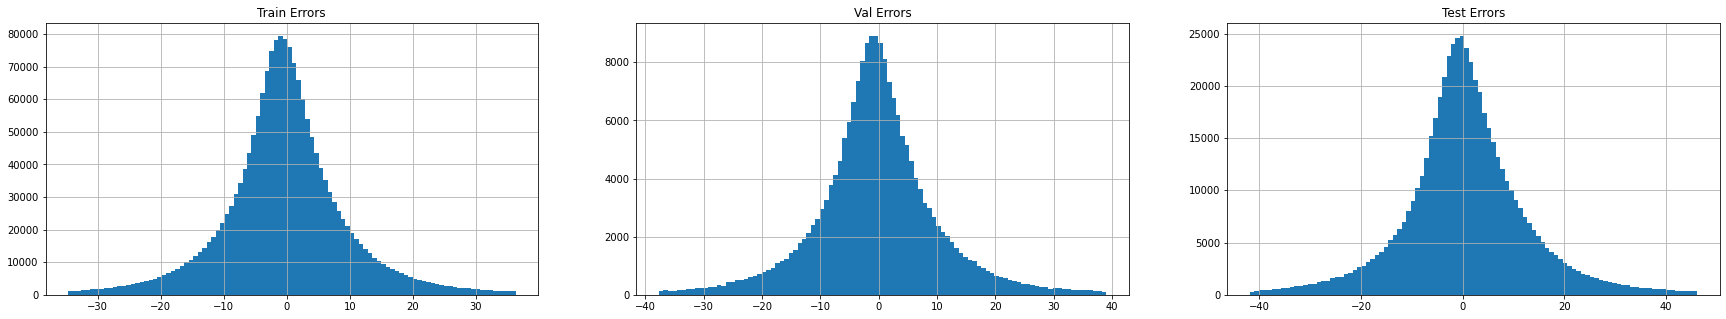

In [110]:
fig, ax = plt.subplots(1, 3, figsize=(30,5))
for i, axes in enumerate(ax):
    if i == 0: 
        filter_column_outliers(train_dataframe_rmval, 'error', .99, .01).error.hist(ax=axes, bins = 100)
        axes.set_title('Train Errors')
    if i == 1: 
        filter_column_outliers(val_dataframe, 'error', .99, .01).error.hist(ax=axes, bins = 100)
        axes.set_title('Val Errors')
    if i == 2: 
        filter_column_outliers(test_dataframe, 'error', .99, .01).error.hist(ax=axes, bins = 100)
        axes.set_title('Test Errors')

In [111]:
debias_constant(train_dataframe_rmval.prediction, train_dataframe_rmval[target_variable], train_dataframe_rmval.error.mean())
debias_constant(val_dataframe.prediction, val_dataframe[target_variable], val_dataframe.error.mean())
debias_constant(test_dataframe.prediction, test_dataframe[target_variable], test_dataframe.error.mean())
debias_constant(test_dataframe.prediction, test_dataframe[target_variable], train_dataframe_rmval.error.mean())

Original bias: -0.36, Original MAE: 7.93, Corrected bias: -0.00, Corrected MAE: 7.91
Original bias: -0.39, Original MAE: 8.55, Corrected bias: -0.00, Corrected MAE: 8.53
Original bias: 0.49, Original MAE: 9.89, Corrected bias: -0.00, Corrected MAE: 9.90
Original bias: 0.49, Original MAE: 9.89, Corrected bias: 0.85, Corrected MAE: 9.90


# Pricing Hypothetical Trades

In [44]:
def get_days(row, col):
    if pd.isna(row[col]) or pd.isna(row['settlement_date']):
        return 0
    else: 
        diff = diff_in_days_two_dates(row[col], row.settlement_date)
        if diff <= 0:
            return -1
        else:
            return diff
        
        
def sample_dataframe(df, N):
    
    group_name = df.name
    def index_to_dict(index_row):
        is_callable = index_row[0]
        interval = str(index_row[1].left)+'-'+str(index_row[1].right)
        rating = index_row[2]
        return {'is_callable':is_callable, 'interval': interval, 'rating':rating}
    
    df = df.drop_duplicates(subset='cusip')
    
    if len(df) < N:
        N = len(df)
    
    np.random.seed(1)
    result = df.sample(N, replace=False) 
    group_id = next(COUNT)
    result['group'] = group_id
    groupby_id_dict[group_id] = index_to_dict(group_name)
    return result


def create_synthetic_samples(df):
    RATINGS = ['AAA',  'BBB', 'CCC', 'NR']
    for cusip in df.cusip.unique():
        temp = df[df.cusip == cusip].iloc[0]
        for rating in RATINGS:
            if rating != temp.rating:
                temp.rating = rating
                df = df.append(temp)
    return df

def make_summary(col):
    # col = 'is_callable'

    summary_df = synthetic_sampled_data.groupby(['cusip'])\
    ['predictions']\
    .agg(['std', max_min_f])\
    .rename({'<lambda_0>':'Max-Min'}, axis=1)\
    
    summary_df = summary_df.join(synthetic_sampled_data.set_index('cusip')[col])
    
    summary_df = summary_df.groupby(col).mean()
    # summary_df.columns = pd.MultiIndex.from_tuples(summary_df.columns)
    
    display(summary_df)
    
    return summary_df

In [45]:
data = test_dataframe[test_dataframe.trade_date <= '2023-06-09'].copy()
# data['days_to_call'] = data[['settlement_date','next_call_date']].apply(lambda x: get_days(x, 'next_call_date'), axis = 1)/NUM_OF_DAYS_IN_YEAR
data['maturity'] = data[['settlement_date','maturity_date']].apply(lambda x: get_days(x, 'maturity_date'), axis = 1)/NUM_OF_DAYS_IN_YEAR
data['maturity_bucket'] = pd.cut(data['maturity'], [0, 5, 10, 15, 20, 30, data.maturity.max()])

In [46]:
RATINGS = ['AAA',  'BBB', 'CCC', 'NR', 'MR']
groupby_cols = ['is_callable','maturity_bucket','rating']

sampled_data = data[data.rating.isin(RATINGS)].groupby(groupby_cols)
COUNT = iter(range(len(sampled_data.groups)))
groupby_id_dict = dict()
sampled_data = sampled_data.apply(lambda x: sample_dataframe(x, 20)).reset_index(drop=True)

In [47]:
%time synthetic_sampled_data = create_synthetic_samples(sampled_data)

CPU times: user 1min 44s, sys: 0 ns, total: 1min 44s
Wall time: 1min 44s


In [48]:
X_sample = create_input_new(sampled_data, trade_history_col, yield_history_cols)
X_sample_hypothetical_trades = create_input_new(synthetic_sampled_data, trade_history_col)

TypeError: create_input_new() takes 2 positional arguments but 3 were given

In [ ]:
sampled_data_predictions  = model.predict(X_sample).flatten()
sampled_data_hypothetical_predictions  = model.predict(X_sample_hypothetical_trades).flatten()

In [ ]:
sampled_data['predictions'] = sampled_data_predictions
synthetic_sampled_data['predictions'] = sampled_data_hypothetical_predictions

In [ ]:
mean_absolute_error(sampled_data['predictions'], sampled_data['new_ys']), mean_absolute_error(synthetic_sampled_data['predictions'], synthetic_sampled_data['new_ys'])

In [ ]:
max_min_f = lambda x: x.max() - x.min()

synthetic_sampled_data['original_rating'] = synthetic_sampled_data['group'].apply(lambda x: groupby_id_dict[x]['rating'])

make_summary('is_callable');
make_summary('original_rating');
make_summary('maturity_bucket');